Notebook used for solving amplitudes that are derived from the $S$-matrix Bootstrap program

Given a set of $B(z)$ that comes from 2207.12448 we try to verify whether elastic unitarity is indeed an emergent property by solving the associated unitarity equation and reconstructing the appropriate phase solution

### General Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, MultiplicativeLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np
from itertools import chain
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Defining the networks

##### $B(z)$ input moduli

In [6]:
class ModuleNetManual(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, type_mod='Crichton', device=torch.device('cpu')):
        super(ModuleNetManual, self).__init__()
        self.type_mod = type_mod
        self.device = device
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function.
        """
    
        if self.type_mod == 'Crichton':
            return torch.sqrt(1.38065 + 3.1118 *x - 1.60815*torch.pow(x,2) - 4.731*torch.pow(x,3) + 6.58* torch.pow(x,4)) # Crichton example
        elif self.type_mod == '4half_approx':
            return func_Bmin4half_approx(x)
        elif self.type_mod == '8_approx':
            return torch.tensor(func_Bmin8_approx(x), device=device).float()
            #return func_Bmin8_approx(x)


The input moduli and phases from the $S$-matrix bootstrap program

In [96]:
def func_Bmin8_approx(x):
    # For this higher order polynomial we ask for extra precision in order to properly resolve it
    if torch.is_tensor(x):
        x = x.numpy().astype(np.float64)
    else:
        x = x.astype(np.float64)
    return  1.328215519203127 - 3.550972618351553*np.power(x,2) + 5.886532003288303*np.power(x,4) - 1.2687025727692265*np.power(x,6) + 168.2650585023763*np.power(x,8) - 2040.021082414207*np.power(x,10) + 16205.564203786662*np.power(x,12) - 86632.67935796695*np.power(x,14) + 311648.3012069155*np.power(x,16) - 772386.7557507973*np.power(x,18) + 1.3346897301006299e6*np.power(x,20) - 1.5790531964530237e6*np.power(x,22) + 1.167337544403004e6*np.power(x,24) - 321819.69044094294*np.power(x,26) - 328635.1933918447*np.power(x,28) + 441527.27853186463*np.power(x,30) - 231305.66665163107*np.power(x,32) + 46320.58010567203*np.power(x,34) + 9856.293393209819*np.power(x,36) - 6936.521109224505*np.power(x,38) + 1055.5776289445132*np.power(x,40)

def func_Bmin8_approx_tensor(x):
    # For the final evaluation of the loss we can keep tensors even if it takes longer
    return  1.328215519203127 - 3.550972618351553*np.power(x,2) + 5.886532003288303*np.power(x,4) - 1.2687025727692265*np.power(x,6) + 168.2650585023763*np.power(x,8) - 2040.021082414207*np.power(x,10) + 16205.564203786662*np.power(x,12) - 86632.67935796695*np.power(x,14) + 311648.3012069155*np.power(x,16) - 772386.7557507973*np.power(x,18) + 1.3346897301006299e6*np.power(x,20) - 1.5790531964530237e6*np.power(x,22) + 1.167337544403004e6*np.power(x,24) - 321819.69044094294*np.power(x,26) - 328635.1933918447*np.power(x,28) + 441527.27853186463*np.power(x,30) - 231305.66665163107*np.power(x,32) + 46320.58010567203*np.power(x,34) + 9856.293393209819*np.power(x,36) - 6936.521109224505*np.power(x,38) + 1055.5776289445132*np.power(x,40)


def func_Bmin4half_approx(x):
    return 0.49086648180811104 + 0.19815490224375532*np.power(x,2) + 0.021128104514067617*np.power(x,4) - 0.008637470850272467*np.power(x,6) + 0.0030366619704871815*np.power(x,8) - 0.0008716249303414227*np.power(x,10) + 0.00017908239359866002*np.power(x,12) - 0.000019186231179770726*np.power(x,14)

In [8]:
def func_phi4half(x):
    return 2.4621625063630157 + 0.2945599505791036*np.power(x,2) - 0.11918458854745756*np.power(x,4) + 0.03969867738294998*np.power(x,6) - 0.00919632861438822*np.power(x,8) + 0.00008189560348349815*np.power(x,10) + 0.001314696004476467*np.power(x,12) - 0.000766413653631638*np.power(x,14) + 0.00022963977237727755*np.power(x,16) - 0.000030581668293801616*np.power(x,18)

def func_phi8(x):
    return 0.6530119672538073 + 2.190482410717558*np.power(x,2) + 5.319055140375412*np.power(x,4) - 7.386198491349271*np.power(x,6) + 330.5640920136576*np.power(x,8) - 5229.028273168294*np.power(x,10) + 49742.897457931576*np.power(x,12) - 321483.9808546457*np.power(x,14) + 1.4108296274367764e6*np.power(x,16) - 4.246908373741916e6*np.power(x,18) + 8.792394900716277e6*np.power(x,20) - 1.2146789380227266e7*np.power(x,22) + 9.85747337094728e6*np.power(x,24) - 1.8292111919638598e6*np.power(x,26) - 4.982425299308547e6*np.power(x,28) + 4.263695874378907e6*np.power(x,30) + 1.0859028905858467e6*np.power(x,32) - 3.417205789642343e6*np.power(x,34) + 950968.5909098412*np.power(x,36) + 1.8962008323223446e6*np.power(x,38) - 2.2091173602299676e6*np.power(x,40) + 1.1014287509803397e6*np.power(x,42) - 280483.9970364112*np.power(x,44) + 29887.326605652026*np.power(x,46)

##### Define the Neural Network Ansatz for $\phi(z)$

In [9]:
class PhiNet(nn.Module):
    def __init__(self, ffnlayers, activation, device='cpu', final_layer='Sigmoid', symmetric=True):
        """
        Initialize the network with the number of FC layers, the activation function, and the device to use
        """
        super(PhiNet, self).__init__()
        
        self.device = device
        self.symmetric = symmetric
        
        if activation=='ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Activation function '{}' not supported. Supported activation functions are 'ReLU' and 'Tanh'".format(activation))

        
        if final_layer=='Sigmoid':
            self.final_layer = nn.Sigmoid()
            self.final_l = 'Sigmoid'
        elif final_layer == 'Tanh':
            self.final_layer = nn.Tanh()
            self.final_l = 'Tanh'
        elif final_layer == 'Identity':
            self.final_layer = nn.Identity()
            self.final_l = 'Identity'
        else:
            raise ValueError("Final layer '{}' not supported. Supported final layers are 'Sigmoid', 'Tanh' and 'Identity'".format(final_layer))

        
        # Create a list of layers from the parameters given. Add the appropriate activation function
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 1)))
        
        # The last layer is sigmoid to constrain outputs between 0 and 1 or tanh for [-1,1]
        layer_list.append(('final_layer', self.final_layer))
            
        
        self.model = nn.Sequential(OrderedDict(layer_list))
    
    
    def forward(self, x):
        """
        Network forward pass where the outputs for the phase are in [-pi, pi]
        """
        if self.symmetric:
            xm = self.model(-x)
            x = self.model(x)
        else:
            xm = self.model(x)
            x = xm
        
        if self.final_l == 'Identity':
            return (x + xm)/2
        if self.final_l == 'Sigmoid':
            return (2*math.pi*x - math.pi + 2*math.pi*xm)/2
        elif self.final_l == 'Tanh':
            return (math.pi*x + math.pi*xm)/2
        else:
            raise ValueError('No good activation function')

### Define the main solver class

##### Solver Definition

Solver class has the loss function definition

In [60]:
class PhaseNetSolver():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, phi_net, mod_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        
        self.epochs = params_simu['epochs_num']
        self.batch_size = params_simu['batch_size']
        self.eval_points_num = params_simu['integral_points']
        self.scaled_loss = params_simu['scaled_loss']
        self.method_int = params_simu['method_int']
        self.p_value = params_simu['p_value']
        self.lambda_repulsive = params_simu['lambda_repulsive']
        self.repulsive_epochs = params_simu['repulsive_epochs']
        self.repulsive_type = params_simu['repulsive_type']
        self.loss_func = params_simu['loss']
        
        
        if isinstance(phi_net, list):
            self.multi_nets = [net.to(device) for net in phi_net]
            self.phi_net = None
            self.multiple_nets = True
        else:
            self.multi_nets = None
            self.phi_net = phi_net.to(device)
            self.multiple_nets = False
        self.mod_net = mod_net.to(device)
        self.device = device
        self.rand_gen = random_generator

        
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        grid_points = self.mod_net(z1_points).view(1,-1,1)*self.mod_net(self.z2(z, z1_points, phi_points))*torch.cos(self.phi_net(z1_points.view(1,-1,1)) - self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral
    
    def loss_function(self, zsamples):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        target = torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        
        model_input = self.integral_approximator(zsamples, method=self.method_int)
        
        # If scaled then all targets should be sin phase
        if self.scaled_loss:
             model_input = model_input / (self.mod_net(zsamples))
            
        # We have different choices of losses. Huber is more stable to outliers.
        if self.loss_func =='Huber':
            loss_out = F.huber_loss(model_input, target, delta=0.1)
        elif self.loss_func == 'MSE':
            loss_out = F.mse_loss(model_input, target)
        else:
            raise NotImplemented
        
        return loss_out
    
    def multi_loss_function(self, zsamples):
        
        if not self.multiple_nets:
            raise NotImplemented
        
        total_loss = 0
        for i, net in enumerate(self.multi_nets):
            self.phi_net = net
            individual_loss = self.loss_function(zsamples)
            total_loss = total_loss + individual_loss
        
        return total_loss

    
    def dual_loss_ambiguity(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        
        net1_val = self.multi_nets[0](zsamples.view(-1,1)).squeeze()
        net2_val = self.multi_nets[1](zsamples.view(-1,1)).squeeze()
        
        target = torch.stack((torch.cos(net1_val), torch.sin(net1_val)))
        model_input1 = torch.stack((torch.cos(net2_val), torch.sin(net2_val)))
        model_input2 = torch.stack((-torch.cos(net2_val), torch.sin(net2_val)))
        
        
        if self.repulsive_type == 'sharp':
            # Sharp repulsive loss
            loss_out1 = torch.pow(F.mse_loss(model_input1, target), -self.p_value)
            loss_out2 = torch.pow(F.mse_loss(model_input2, target), -self.p_value)

        elif self.repulsive_type == 'decay':
            # Repulsive loss with decay
            loss_out1 = 1-torch.tanh(self.p_value * F.mse_loss(model_input1, target))
            loss_out2 = 1-torch.tanh(self.p_value * F.mse_loss(model_input2, target))
        else:
            raise ValueError('Correct type of repulsion not specified')
        
        return loss_out1 + loss_out2
        
    def complete_loss(self, zsamples, dual_active):
        
        if not self.multiple_nets:
            return self.loss_function(zsamples)
        else:
            if len(self.multi_nets)!=2:
                raise NotImplemented
            if dual_active:
                repulsive_loss = self.dual_loss_ambiguity(zsamples)
            else: 
                repulsive_loss = 0.0
            
            unitarity_loss = self.multi_loss_function(zsamples)
            
            if repulsive_loss * 10 > unitarity_loss and self.lambda_repulsive>0.0:
            
                return unitarity_loss + self.lambda_repulsive * repulsive_loss
            else:
                return unitarity_loss
    
    def point_loss(self, zsamples):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        target = torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        model_input = self.integral_approximator(zsamples)
        
        if self.scaled_loss:
            model_input = model_input / (self.mod_net(zsamples))
        return torch.square(model_input - target)
        
    def train(self):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        
        p_value_init = self.p_value
        tq_iterator = tqdm(range(self.epochs), unit='epoch', leave=False)
        
        for epoch_num in tq_iterator:
            
            if self.repulsive_type is None:
                dual_active = False
            elif self.repulsive_type == 'sharp':
                dual_active = False if self.repulsive_epochs is None or epoch_num < self.repulsive_epochs[0] or epoch_num > self.repulsive_epochs[1] else True
            elif self.repulsive_type == 'decay':
                dual_active = True
                self.p_value = repulsive_decay_func(p_value_init, epoch_num, self.repulsive_epochs)
                
            
            # Set the network in train mode
            if self.multiple_nets:
                for net in self.multi_nets:
                    net.train()
            else:
                self.phi_net.train()
            
            if self.device is not torch.device('cuda'):
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1
            else:
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device=self.device)*2 - 1
            
            # Zero the grads, get the loss and backpropagate
            
            if type(self.optimizer).__name__ == 'LBFGS':
                
                loss = self.complete_loss(zpoints, dual_active)
                
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer.zero_grad()
                    loss_comp = self.complete_loss(zpoints, dual_active)
                    if loss_comp.requires_grad:
                        loss_comp.backward()
                    return loss_comp
                
                self.optimizer.step(closure)
                   
            else:
                self.optimizer.zero_grad()
                loss = self.complete_loss(zpoints, dual_active)
                loss.backward()
                
                self.optimizer.step()
                
            if self.scheduler is not None:
                self.scheduler.step()
            
            tq_iterator.set_description('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num,loss.item()))

Define the helper functions for the learning rate scheduler and the repulsive loss

In [61]:
def scheduler_rate_exp(step, gamma, max_ep):
    """
    For the Exponential Learning Rate scheduler where we decay only after the repulsive loss
    
    # Should probably do this with MultiplicativeLR instead
    """
    if step < 0.3 * min(5000, max_ep):
        return 1
    else:
        return gamma

def repulsive_decay_func(p_value_init, epoch_num, repulsive_epochs, overall_scale=16):
    """
    Construct a profile function for the increase in the temperature parameter used
    in the repulsive loss
    """
    
    # Construct a hyperbolic tanh function with a maximum slope at the middle of the repulsive interval
    # The hyperbolic function reaches 0.99 at the end of the repulsive interval
    a = (repulsive_epochs[0] + repulsive_epochs[1])/(2*math.atanh((100-99*overall_scale)/(100-101*overall_scale)))
    b = (repulsive_epochs[1] - repulsive_epochs[0])/(2*a)
    
    delta1 = p_value_init *(101*overall_scale - 100) /200
    delta2 = p_value_init *(99*overall_scale + 100) /200
    
    return delta1*np.tanh(-b+epoch_num/a) + delta2

##### Training and evaluation routines defintions

In [62]:
def train_run(parameters, device, module_net=None, phi_net=None, seed_num=42, optim_name='Adam'):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    num_phi_nets = parameters['num_nets']
    
    # Define and register the networks
    if num_phi_nets>1:
        phinn = [PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer'], symmetric=parameters['symmetric']) for i in range(num_phi_nets)]
    else:
        if phi_net is None:
            phinn = PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer'], symmetric=parameters['symmetric'])
        else:
            phinn = phi_net
        
    if module_net is None:
        modnn = ModuleNetManual()
    else:
        modnn = module_net
            
    # Define and register the optimizer and scheduler
    if optim_name == 'Adam':
        if num_phi_nets>1:
            optimizer = torch.optim.Adam(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
        else:
            optimizer = torch.optim.Adam(phinn.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
    elif optim_name == 'LBFGS':
        if num_phi_nets>1:
            optimizer = torch.optim.LBFGS(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)
        else:
            optimizer = torch.optim.LBFGS(phinn.parameters(), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)
    
    if parameters['lr_scheduler']:
        lr_scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate_exp(step, 0.999, parameters['epochs_num']))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolver(parameters, phinn, modnn, optimizer, random_gen_cpu, lr_scheduler, device=device)
    netsolver.train()

    return netsolver

In [63]:
def eval_run(trained_solver, params, device, steps_eval=100, num=None):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    str_add = '_' + str(num) if num is not None else ''
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        results = trained_solver.phi_net(zpointstest.view(-1,1))
        phires = results.squeeze().cpu().numpy()
        sinphires = torch.sin(results).squeeze().cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        eval_point_loss_scaled = trained_solver.point_loss(zpointstest)
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        eval_point_loss_non_scaled = trained_solver.point_loss(zpointstest)
    
    return zpointstest, phires, sinphires, eval_point_loss_scaled, eval_point_loss_non_scaled

### Solving the $S$-Matrix phases

##### Helper function for extracting the Legendre partial wave coefficients and calculating the unitarity loss

In [64]:
from scipy.integrate import quad
from scipy.special import eval_legendre

def legendre_coeffs(modf, phase_net, ncoeff):
    
    phase_net.eval()
    with torch.no_grad(): 
        real_part = quad(lambda z: np.real(eval_legendre(ncoeff, z)*np.exp(1j*phase_net(torch.tensor(z).view(-1,1)).numpy()[0,0])*modf(np.array(z))), -1, 1, limit=1000, epsabs=1e-12, epsrel=1e-12)[0]/2
        im_part = quad(lambda z: np.imag(eval_legendre(ncoeff, z)*np.exp(1j*phase_net(torch.tensor(z).view(-1,1)).numpy()[0,0])*modf(np.array(z))), -1, 1, limit=1000, epsabs=1e-12, epsrel=1e-12)[0]/2
        
        return real_part +1j*im_part

In [65]:
def z2(z, z1, phi):
    """
    Compute the z2 parameter (formula in motivation)
    Place the batch size on first dim, z1 on the second and phi on the third
    """
    term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
    term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
    return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)

def integral_approximator(z, func_mod, func_phase, method='trapz', eval_points_num=100):
    """
    Approximate the value of the RHS of the integral equation.
    Compute the grids of z1 and phi points for given z values and integrate over the grids
    """
    # Linear partition of the space
    z1_points = torch.linspace(-1,1,steps=eval_points_num, requires_grad=False)
    phi_points = torch.linspace(0, 2*math.pi, steps=eval_points_num, requires_grad=False)
    dx_z1 = 2/(eval_points_num-1)
    dx_phi = 2*math.pi/(eval_points_num-1)
    
    grid_points = func_mod(z1_points).view(1,-1,1)*func_mod(z2(z, z1_points, phi_points))*torch.cos(func_phase(z1_points.view(1,-1,1)) - func_phase(z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())
    
    # Simple trapezoid exists in PyTorch
    if method == 'trapz':
        integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
    
    return integral

def unitarity_loss(z, func_mod, func_phase, eval_points_num=100):
    """
    Calculate the unitarity loss at every point
    """
    
    ztest = torch.linspace(-1,1,eval_points_num)
    approx_int = integral_approximator(ztest, func_mod, func_phase, eval_points_num=eval_points_num)
    target_eq = torch.sin(func_phase(ztest.view(-1,1)).squeeze())
    
    return (target_eq-(approx_int/func_mod(ztest)))**2

##### Plot the relevant differential cross section

In [66]:
net_mod1 = ModuleNetManual(type_mod='8_approx')
z_pointst = torch.linspace(-1,1,steps=1000, device=device)
net_b1 = net_mod1(z_pointst)

net_mod2 = ModuleNetManual(type_mod='4half_approx')
z_pointst = torch.linspace(-1,1,steps=1000, device=device)
net_b2 = net_mod2(z_pointst)

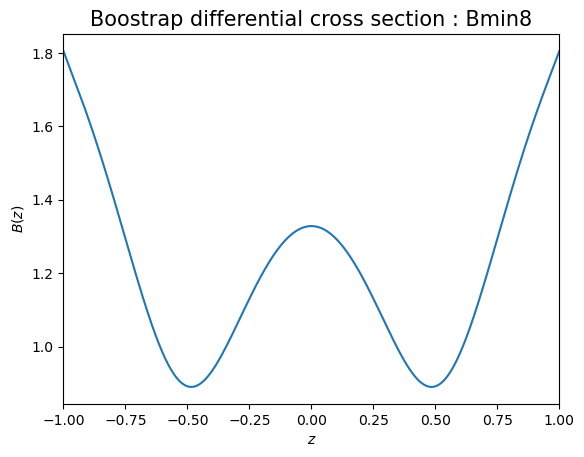

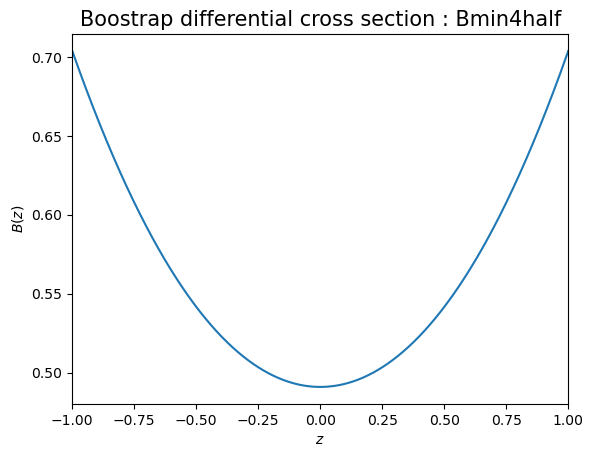

In [67]:
import matplotlib.pyplot as plt
plt.plot(z_pointst.cpu(), net_b1.cpu())
plt.xlabel('$z$')
plt.ylabel('$B(z)$')    
plt.title('Boostrap differential cross section : Bmin8', fontsize = 15)
plt.xlim([-1,1])
plt.show()

plt.plot(z_pointst.cpu(), net_b2.cpu())
plt.xlabel('$z$')
plt.ylabel('$B(z)$')    
plt.title('Boostrap differential cross section : Bmin4half', fontsize = 15)
plt.xlim([-1,1])
plt.show()

##### General Plotting Routines

In [68]:
import matplotlib.pyplot as plt

def sin_mu_integral(params, device, trained_solver, zpoints):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    z1_points = torch.linspace(-1,1,steps=params['integral_points'], device=device)
    phi_points = torch.linspace(0, 2*math.pi, steps=params['integral_points'], device=device)
    dx_z1 = 2/(params['integral_points']-1)
    dx_phi = 2*math.pi/(params['integral_points']-1)
        
    grid_points = trained_solver.mod_net(z1_points).view(1,-1,1)*trained_solver.mod_net(netsolver.z2(zpoints, z1_points, phi_points))
        
    integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
    return integral/trained_solver.mod_net(zpoints)

def plot_phase(zpoints, phipoints):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()
    plt.close(fig)
    
def plot_phases(zpoints, phipoints_list):

    fig = plt.figure(figsize=(14, 10))
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.legend(['Network {}'.format(i+1) for i in range(len(phipoints_list))])
    plt.xlim([-1,1])
    plt.show()
    plt.close(fig)
    
    
def plot_point_loss(zpoints, point_loss_data_s, point_loss_data_no_s):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), 'b-', linewidth = 2)  
    plt.plot(zpoints.cpu(), np.log10(point_loss_data_no_s.cpu()), 'g-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Normalized loss at each point', 'Base loss'])
    plt.show()
    plt.close(fig)
    

def plot_sin_mu(zpoints, integralpoints):

    sinmu = max(integralpoints.cpu())

    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    
def plot_summary(zpoints, phipoints, sinphipoints, integralpoints):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.plot(zpoints.cpu(),sinphipoints, 'b--', linewidth = 2)       
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.xlim([-1,1])
    plt.legend(['$\phi(z)$', '$\sin \phi(z)$','$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    plt.close(fig3)

##### Training the first $B(z)$ at $s=4.5m^2$

Define the training parameters and launch the training run

In [69]:
params = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.003,
         'repulsive_epochs': None,
         'repulsive_type' : None,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'symmetric': True,
         'loss': 'MSE',
         'scaled_loss': True,
         'num_nets' : 1,
         'p_value': 2,
         'lambda_repulsive': 0.0}

In [70]:
netsolver = train_run(params, device, ModuleNetManual(type_mod='4half_approx'), seed_num=0, optim_name='Adam')

  0%|          | 0/5000 [00:00<?, ?epoch/s]

Evaluate the final loss and solution. Generate the appropriate plot

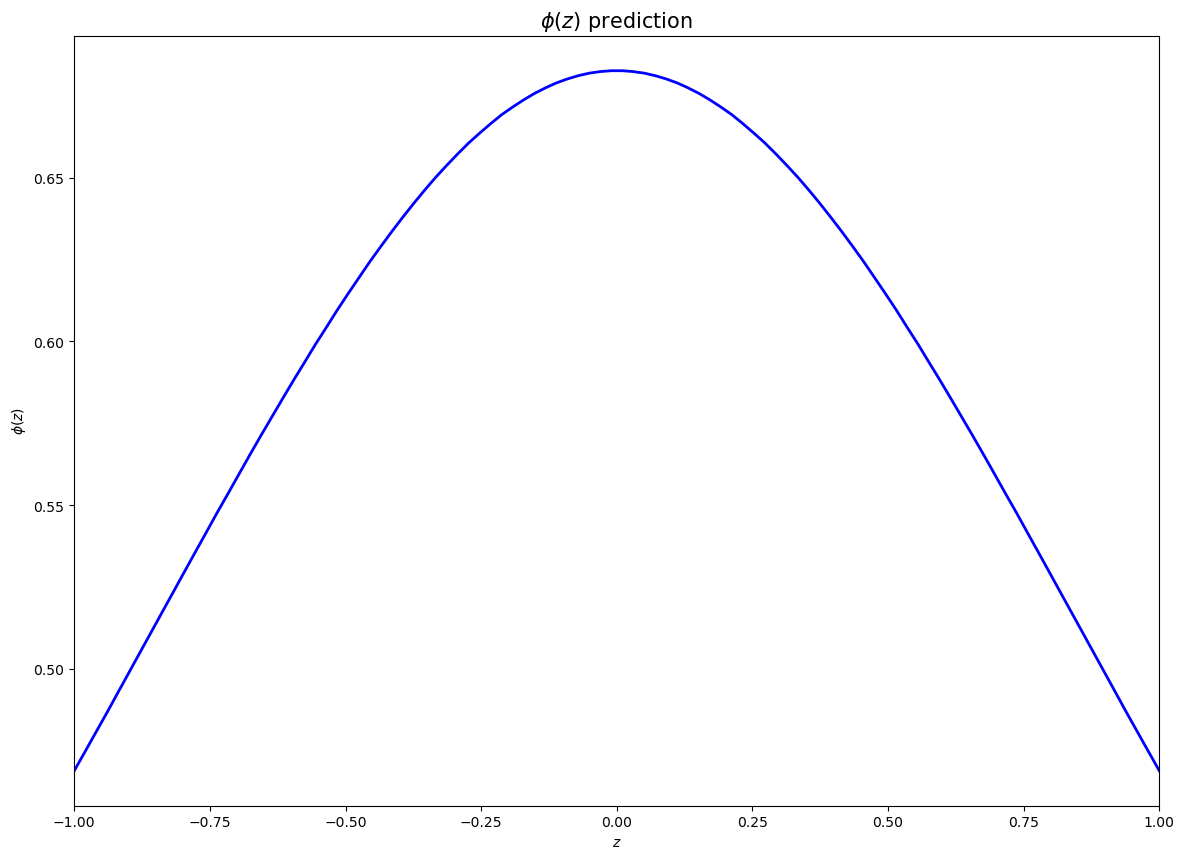

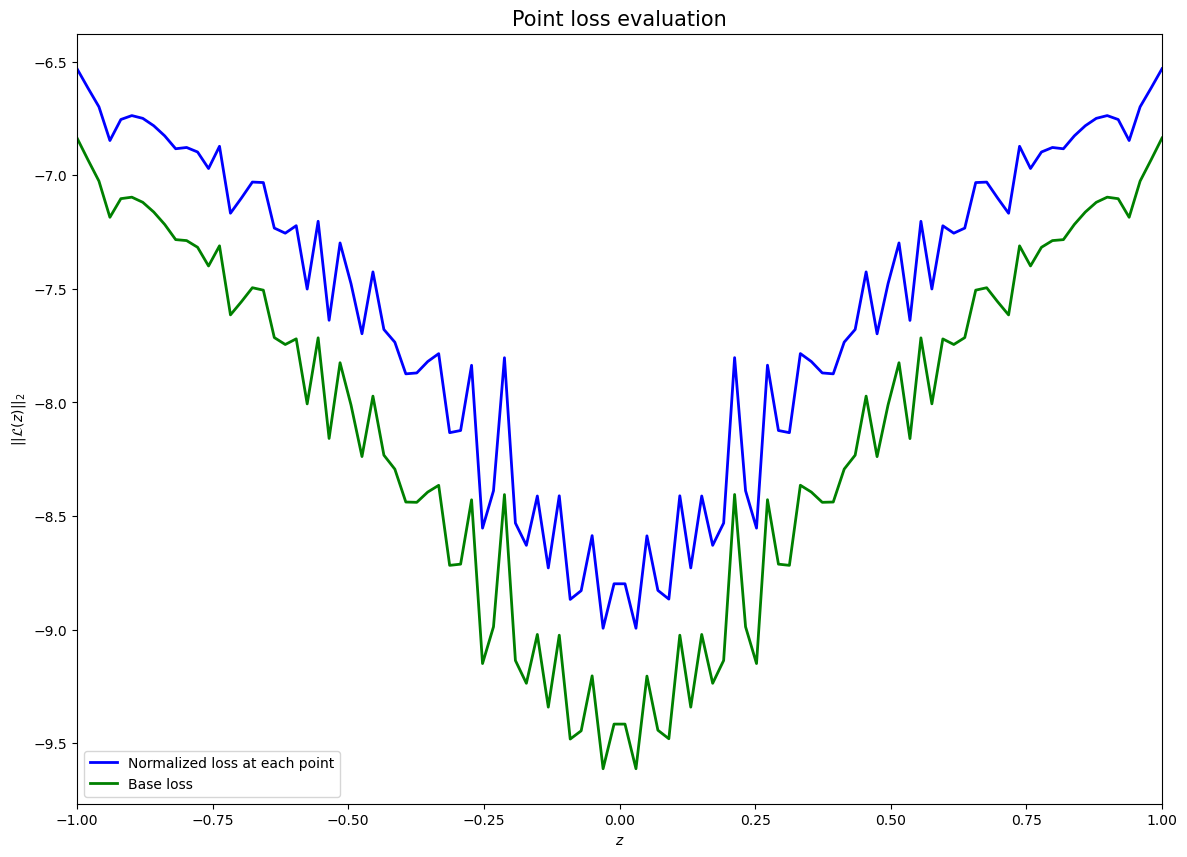

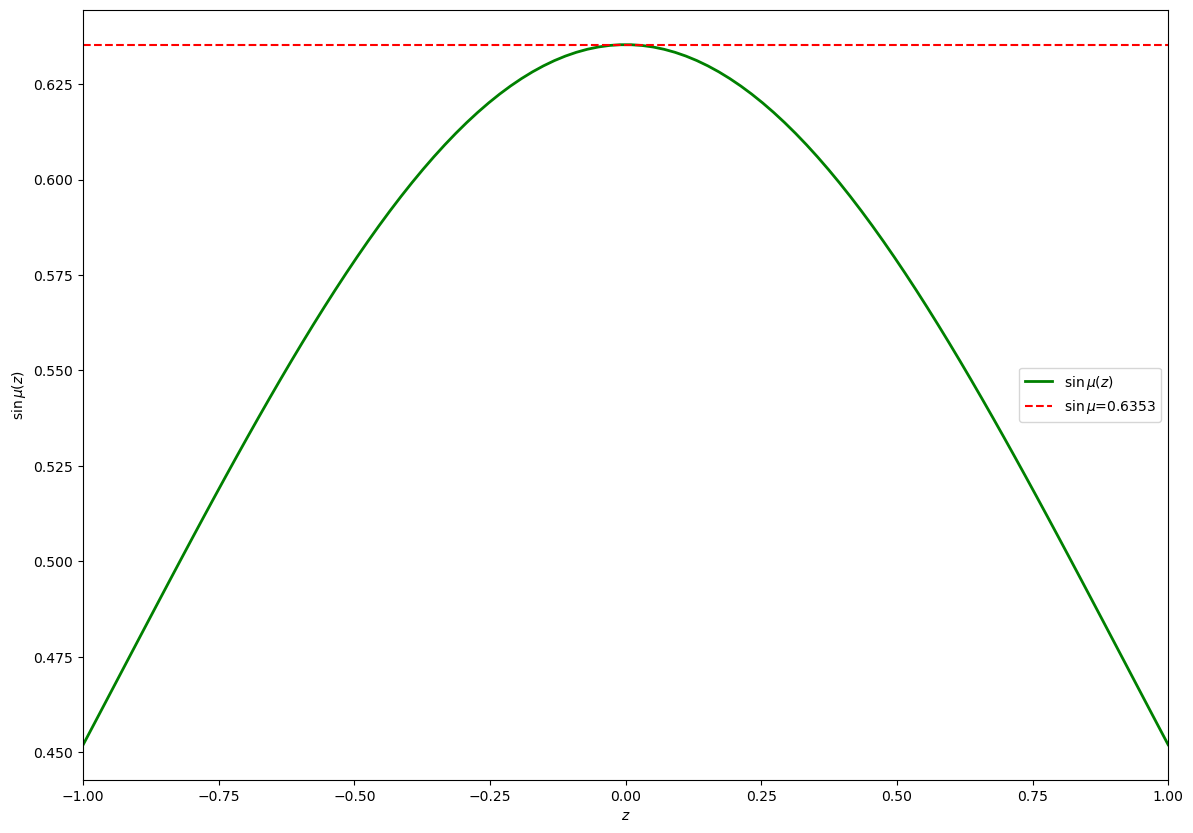

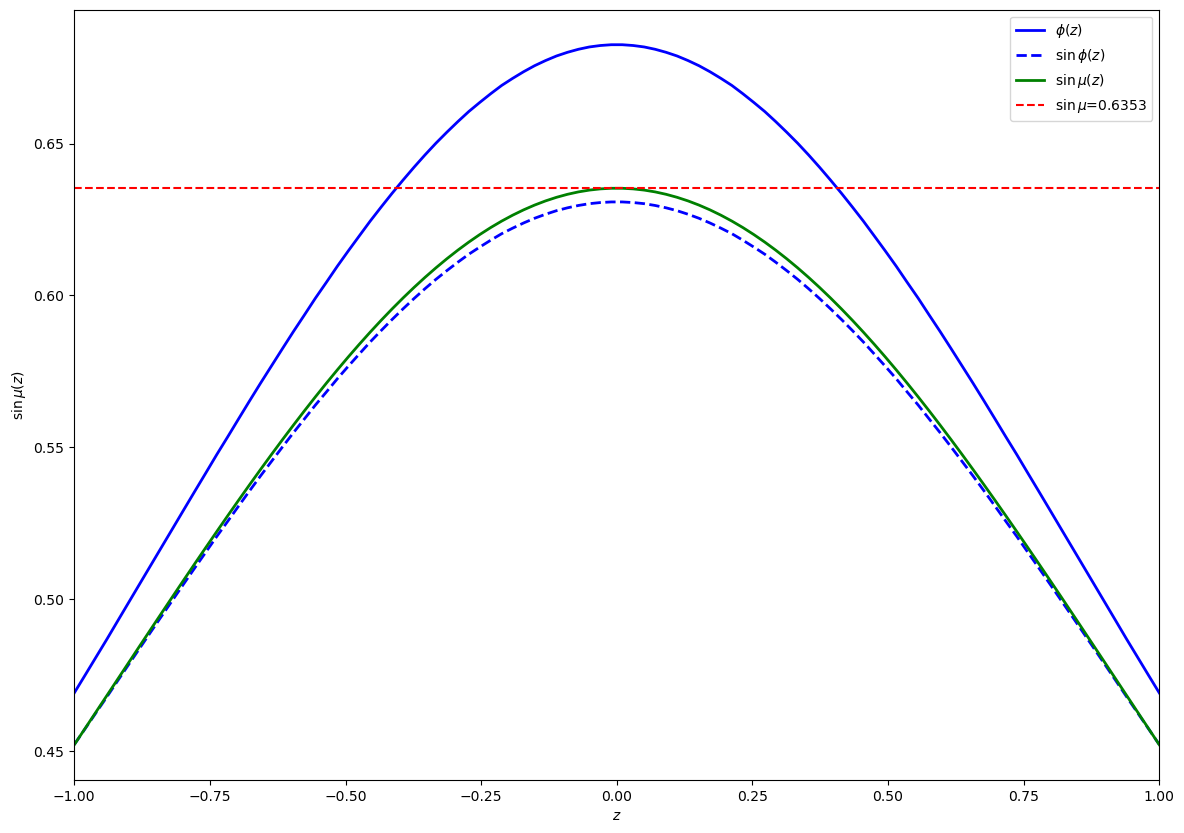

In [81]:
netsolver.eval_points_num = 100
zpointseval, phieval, sinphieval, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver, params, device)

plot_phase(zpointseval, phieval)
plot_point_loss(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz)

plot_summary(zpointseval, phieval, sinphieval, integralz)

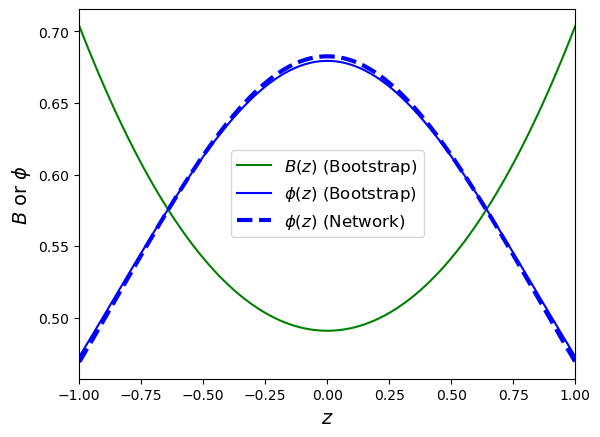

In [82]:
z_pointst = torch.linspace(-1,1,steps=100, device=device)
net_b = func_Bmin4half_approx(z_pointst.cpu().detach().numpy().astype(np.float64))
phi_b = func_phi4half(z_pointst.cpu().detach().numpy().astype(np.float64))
with torch.no_grad():      
    phase_b = netsolver.phi_net(z_pointst.view(-1,1))
    
plt.plot(z_pointst.cpu(), net_b, c='g',linewidth = 1.5)
plt.plot(z_pointst.cpu(), math.pi-phi_b,c='b',linewidth = 1.5)
plt.plot(z_pointst.cpu(), phase_b.cpu(),c='b',linestyle='--',linewidth = 3)
plt.xlabel('$z$', fontsize=14)
plt.legend(['$B(z)$ (Bootstrap)' , '$\phi(z)$ (Bootstrap)', '$\phi(z)$ (Network)'], fontsize=12)
plt.ylabel('$B$ or $\phi$', fontsize=14)    
plt.xlim([-1,1])
plt.show()

##### Evaluate the unitarity loss at $s=4.5m^2$ and compare to the loss of the bootstrap phase

In [92]:
u_loss_1 = unitarity_loss(zpointseval, func_Bmin4half_approx, func_phi4half, eval_points_num=100)

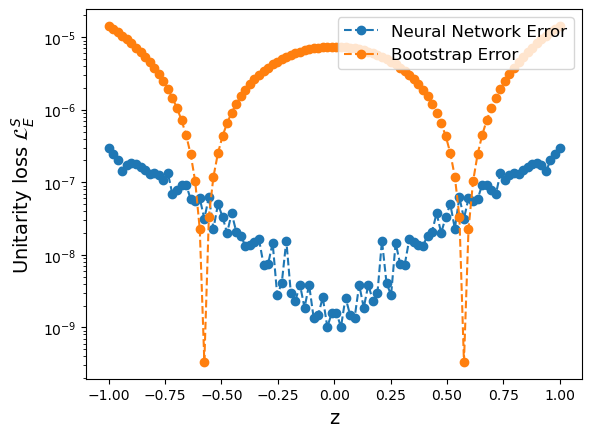

In [85]:
plt.plot(zpointseval, eval_pt_loss_s, '--o')
plt.plot(zpointseval, u_loss_1, '--o')
plt.yscale("log")
plt.xlabel('z', fontsize=14)
plt.ylabel('Unitarity loss $\mathcal{L}_E^S$', fontsize=14)
plt.legend(['Neural Network Error', 'Bootstrap Error'], fontsize=12, loc='upper right')

plt.show()

##### Training the second $B(z)$ at $s=8m^2$

Training loop

In [86]:
from copy import deepcopy

params2 = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.003,
         'repulsive_epochs': None,
         'repulsive_type' : None,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'symmetric': True,
         'loss': 'MSE',
         'scaled_loss': True,
         'num_nets' : 1,
         'p_value': 2,
         'lambda_repulsive': 0.0}

In [87]:
netsolver2 = train_run(params2, device, ModuleNetManual(type_mod='8_approx'), seed_num=0, optim_name='Adam', phi_net=deepcopy(netsolver.phi_net))

  0%|          | 0/5000 [00:00<?, ?epoch/s]

Evaluate the solution and plot it

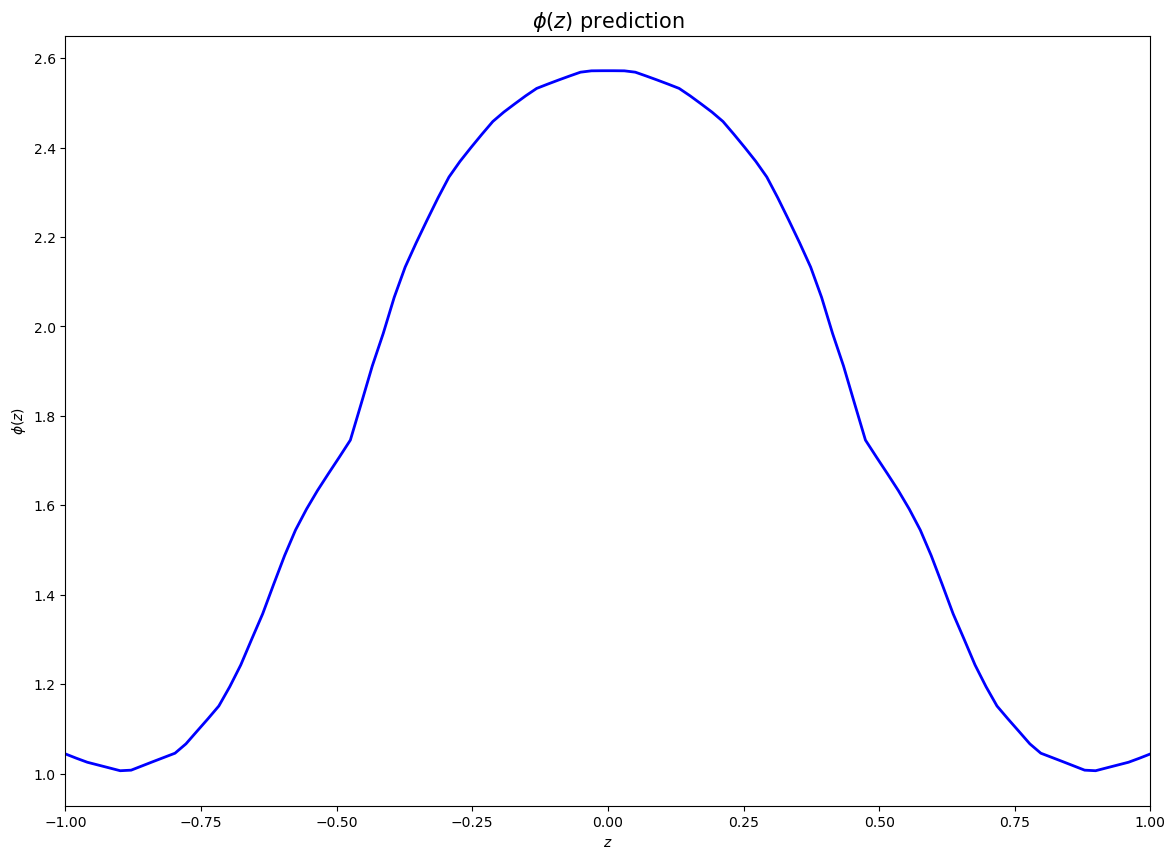

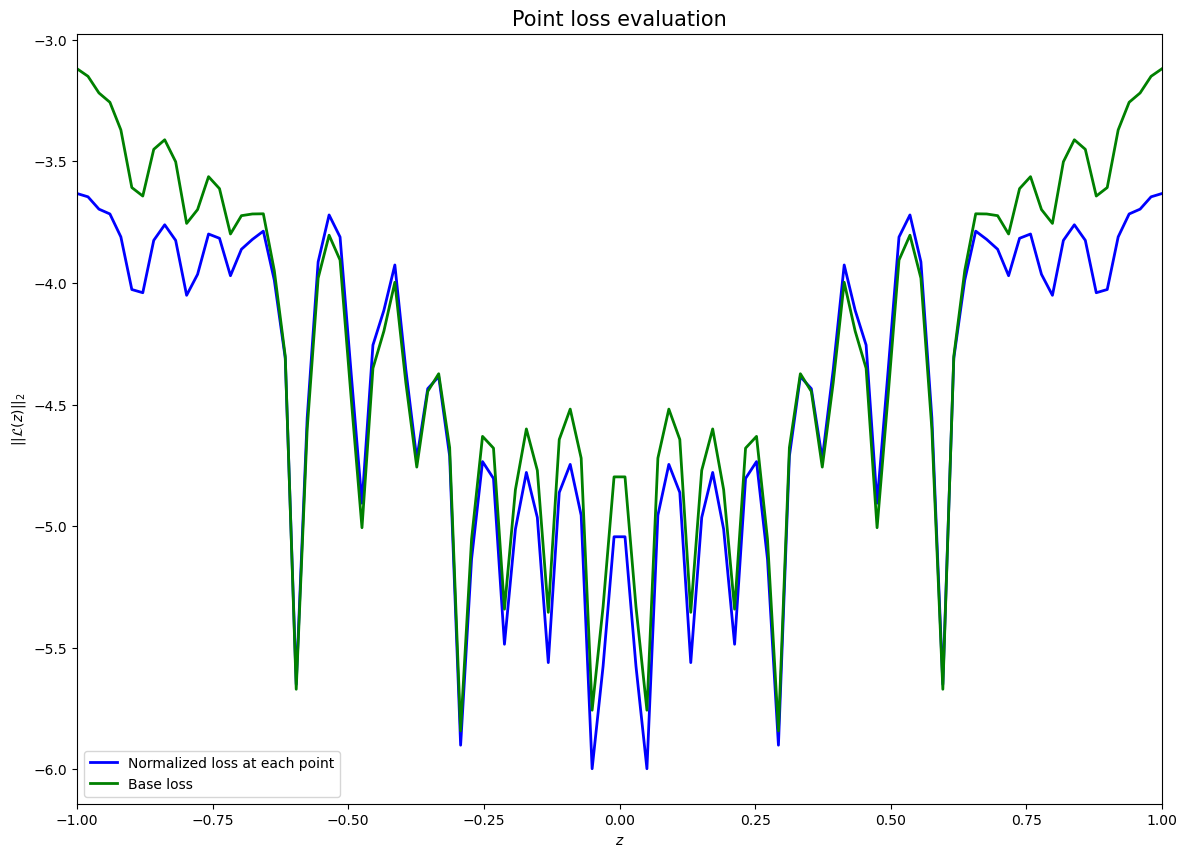

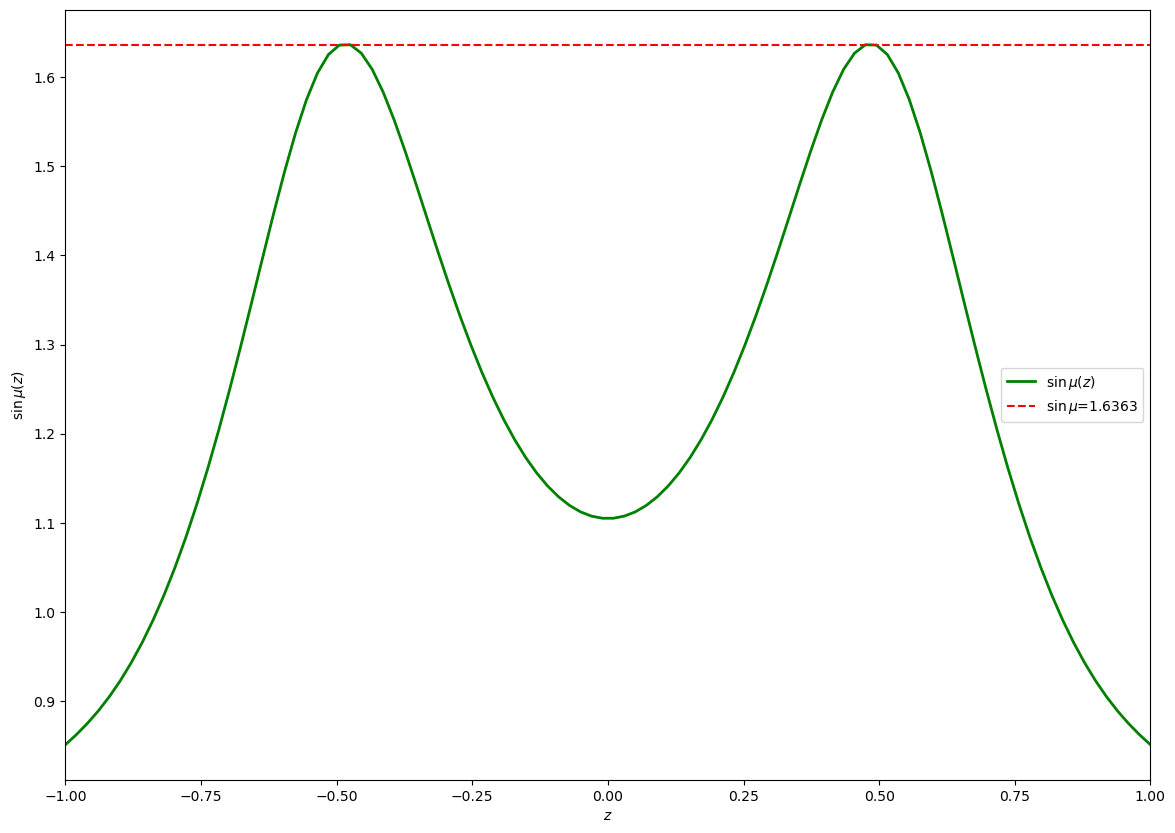

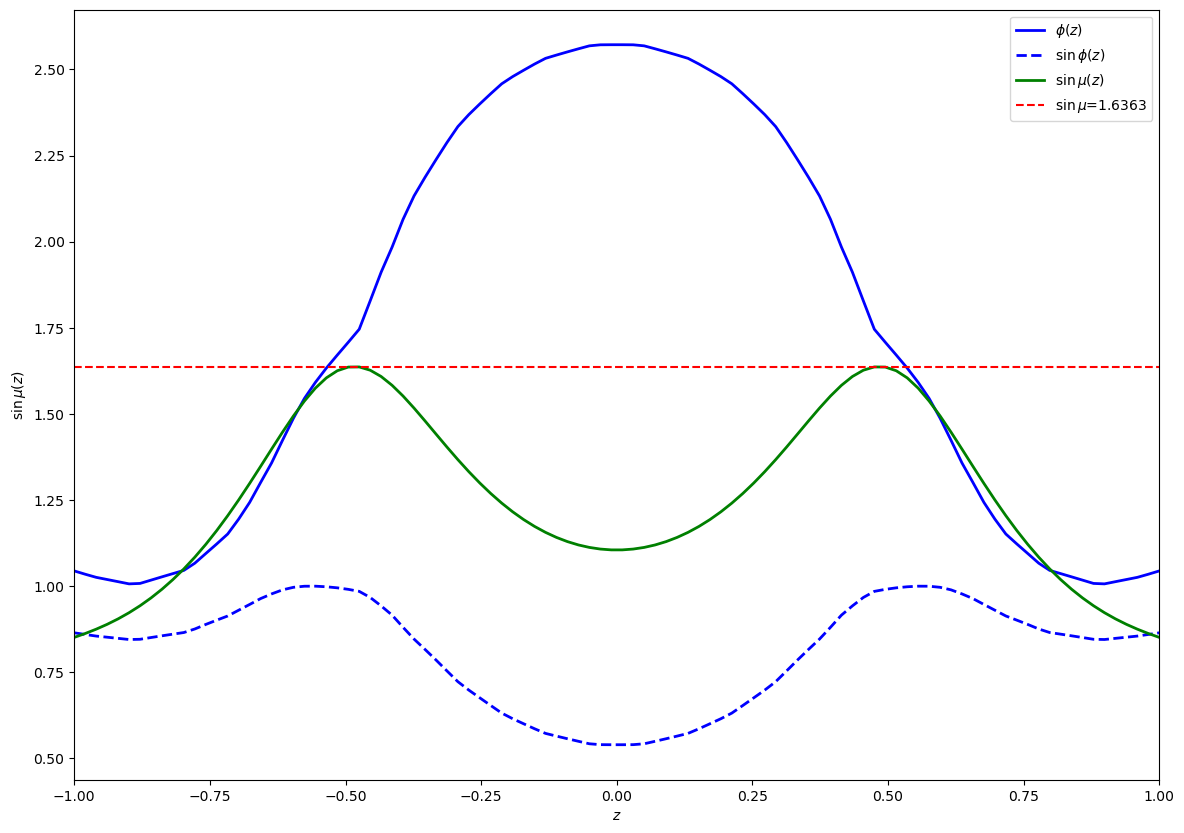

In [88]:
netsolver2.eval_points_num = 100

zpointseval2, phieval2, sinphieval2, eval_pt_loss_s2, eval_pt_loss_no_s2 = eval_run(netsolver2, params2, device)

plot_phase(zpointseval2, phieval2)
plot_point_loss(zpointseval2, eval_pt_loss_s2, eval_pt_loss_no_s2)

integralz2 = sin_mu_integral(params2, device, netsolver2, zpointseval2)
plot_sin_mu(zpointseval2, integralz2)

plot_summary(zpointseval2, phieval2, sinphieval2, integralz2)

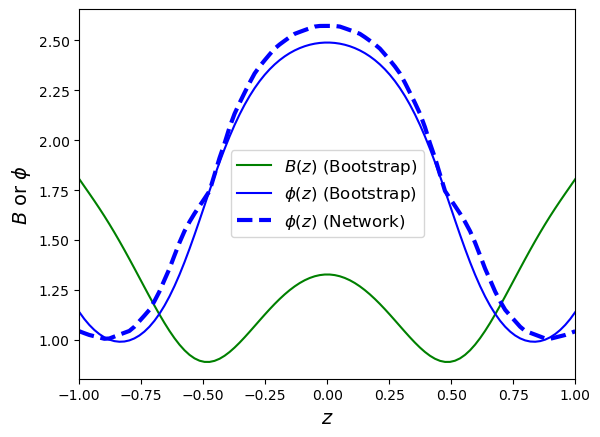

In [89]:
z_pointst = torch.linspace(-1,1,steps=100, device=device)
net_b = func_Bmin8_approx(z_pointst.cpu().detach().numpy().astype(np.float64))
phi_b = func_phi8(z_pointst.cpu().detach().numpy().astype(np.float64))
with torch.no_grad():      
    phase_b = netsolver2.phi_net(z_pointst.view(-1,1))

plt.plot(z_pointst.cpu(), net_b, c='g',linewidth = 1.5)
plt.plot(z_pointst.cpu(), math.pi-phi_b,c='b',linewidth = 1.5)
plt.plot(z_pointst.cpu(), phase_b.cpu(),c='b',linestyle='--',linewidth = 3)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$B$ or $\phi$', fontsize=14)    
plt.xlim([-1,1])

plt.legend(['$B(z)$ (Bootstrap)' , '$\phi(z)$ (Bootstrap)', '$\phi(z)$ (Network)'], fontsize=12)


plt.show()

##### Evaluate the unitarity loss at $s=8m^2$ and compare to the loss of the bootstrap phase

In [114]:
z_eval_precise = torch.linspace(-1,1,steps=100, device=device,dtype=torch.float64)
u_loss_2 = unitarity_loss(z_eval_precise, func_Bmin8_approx_tensor, func_phi8, eval_points_num=100)

The integral is rough but can also do it more precisely in Mathematica to get the final picture

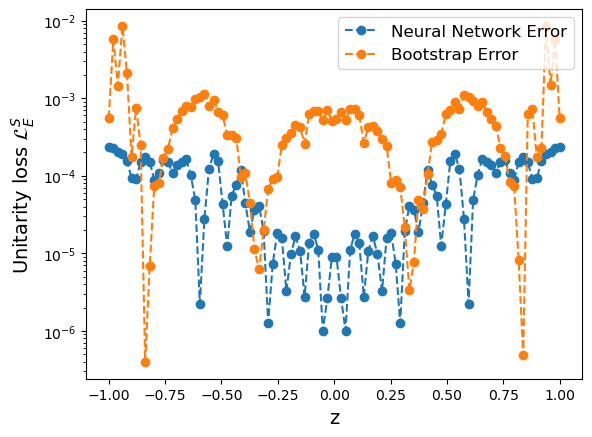

In [118]:
plt.plot(zpointseval2, eval_pt_loss_s2, '--o')
plt.plot(z_eval_precise, u_loss_2, '--o')

plt.yscale("log")
plt.legend(['Neural Network Error', 'Bootstrap Error'], fontsize=12, loc='upper right')
plt.xlabel('z', fontsize=14)
plt.ylabel('Unitarity loss $\mathcal{L}_E^S$', fontsize=14)
plt.show()

In [116]:
import csv 

# Replace the csv path (Here is the data path in the GitHub project)

u_loss_2_mma_data = []
fileerr_2_mma= open("Data/Bootstrap/errors2a.csv", 'r')
u_loss_2_mma_data.append(list(csv.reader(fileerr_2_mma, delimiter=',', quoting = csv.QUOTE_NONNUMERIC)))

zpt2a = np.array(u_loss_2_mma_data[0])[:,0]
u_loss_2_mma = np.array(u_loss_2_mma_data)[0][:,1]

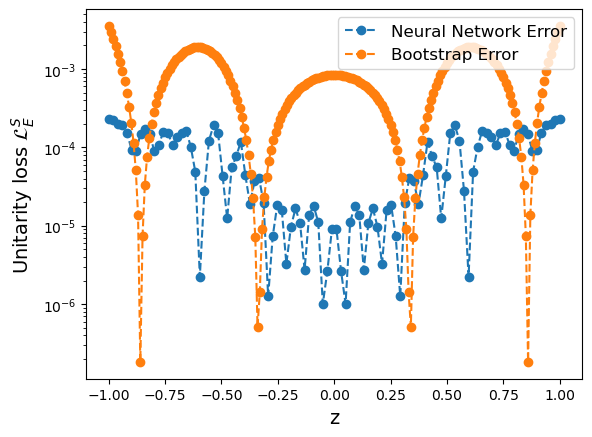

In [117]:
plt.plot(zpointseval2, eval_pt_loss_s2, '--o')
plt.plot(zpt2a, u_loss_2_mma, '--o')

plt.yscale("log")
plt.legend(['Neural Network Error', 'Bootstrap Error'], fontsize=12, loc='upper right')
plt.xlabel('z', fontsize=14)
plt.ylabel('Unitarity loss $\mathcal{L}_E^S$', fontsize=14)
plt.show()